In [1]:
!pip install wordcloud


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


0       Here’s the original: <a href="https://x.com/bo...
1                                 What an eye opener.....
2       This is amazing. <br><br>Do not yield to the a...
3                                                       .
4       Don&#39;t let somebody else pick your friends ...
                              ...                        
8084                         He whopped WEF&#39;s asses 😂
8085    no time for a 20min video at the moment, could...
8086             Agree 100% Spread this Ike wildfire!!!!!
8087                                        Thanks Farzad
8088                                     Tesla Cybertruck
Name: comment, Length: 8089, dtype: object
-----------------------------------------------
0       heres the original  the ai edited version usin...
1                                      what an eye opener
2       this is amazing do not yield to the advance of...
3                                                    None
4       dont let somebody else pick you

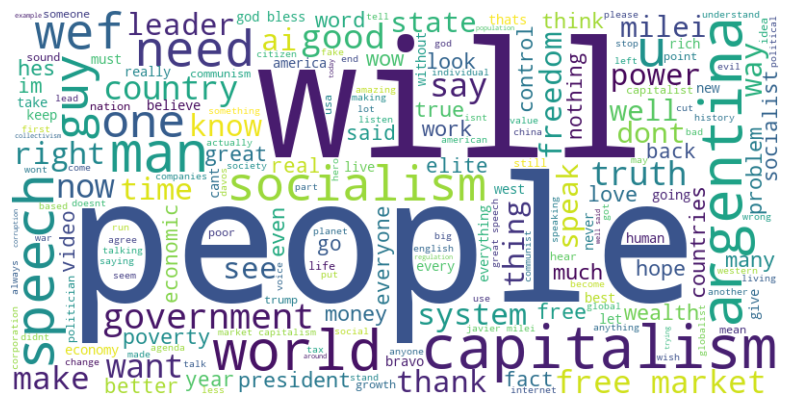

In [2]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import html

# Leer el archivo CSV
df = pd.read_csv("../dataset/comments.csv")

# Convertir los valores de la columna 'comment' a cadenas de texto
df['comment'] = df['comment'].astype(str)

print(df['comment'])

#TODO ver que onda si hay que filtrar algo mas

# Función para limpiar los comentarios
def clean_comment(comment):
    # Decodificar entidades HTML
    comment = html.unescape(comment)
    # Eliminar etiquetas HTML
    comment = re.sub(r'<.*?>', '', comment)
    # Eliminar caracteres especiales y entidades HTML restantes
    comment = re.sub(r'&\w+;', '', comment)
    # Eliminar enlaces
    comment = re.sub(r'http\S+', '', comment)
    # Eliminar caracteres de puntuación y números
    comment = re.sub(r'[^\w\s]', '', comment)
    # Convertir a minúsculas
    comment = comment.lower()
    
    # Retornar None si el comentario está vacío después de la limpieza
    if comment == "" or len(comment) == 0 or comment == "nan" or re.match(r'^\s*$', comment):
        return None
    return comment

# Limpiar los comentarios
df['clean_comment'] = df['comment'].apply(clean_comment)

# Filtrar comentarios que no son None
clean_comments = df['clean_comment'].dropna()

print("-----------------------------------------------")
print(df['clean_comment'])

# Concatenar todos los comentarios en un solo string
all_comments = " ".join(clean_comments)

# Guardar los comentarios limpios en un archivo CSV
output_file_path = 'clean_comments.csv'
clean_comments.to_csv(output_file_path, index=False)

# Verificar que el archivo se haya creado
try:
    with open(output_file_path, 'r') as file:
        print(f"Archivo '{output_file_path}' creado exitosamente.")
except FileNotFoundError:
    print(f"Error: No se pudo encontrar o crear el archivo '{output_file_path}'.")

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

# Mostrar la imagen del WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [3]:
# Calcular la longitud de cada comentario en caracteres
df['comment_length'] = df['clean_comment'].apply(len)

# Calcular el promedio y la desviación estándar de la longitud de los comentarios
avg_length = df['comment_length'].mean()
std_length = df['comment_length'].std()

# Graficar el promedio y la desviación estándar de la longitud de los comentarios
plt.figure(figsize=(8, 6))
plt.bar(['Promedio'], [avg_length], yerr=std_length, color='skyblue', capsize=7)
plt.ylim(0, None)  # Ajustar el límite inferior del eje y a 0
plt.ylabel('Longitud Promedio del Comentario')
plt.title('Promedio de la Longitud de los Comentarios con Desviación Estándar')
plt.show()

TypeError: object of type 'NoneType' has no len()

In [12]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Descargar recursos necesarios de NLTK
# nltk.download('vader_lexicon')

# Análisis de Sentimientos
sid = SentimentIntensityAnalyzer()

def analyze_sentiment(comment):
    scores = sid.polarity_scores(comment)
    if scores['compound'] >= 0.05:
        return 'Positive'
    elif scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['clean_comment'].apply(analyze_sentiment)

# Mostrar resultados del análisis de sentimientos
print(df[['clean_comment', 'sentiment']])

# Clasificación de los Comentarios
# Asegúrate de que tu dataset tenga una columna 'category' para las etiquetas
# Si no tienes esta columna, debes crearla de alguna manera para entrenar el modelo
# Aquí se asume que existe una columna 'category' en tu dataset

if 'category' in df.columns:
    # Convertir los comentarios en vectores TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df['clean_comment'])

    y = df['category']

    # Dividir los datos en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crear y entrenar el modelo KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)

    # Predecir en el conjunto de prueba
    y_pred = knn.predict(X_test)

    # Mostrar los resultados
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Classification Report:')
    print(classification_report(y_test, y_pred))

    # Procesar el resto del dataset (sin etiquetas)
    # Por ejemplo, si tienes un nuevo conjunto de comentarios sin categorías
    new_comments = pd.Series([
        "Great conference, very informative!",
        "I didn't enjoy the conference.",
        "The speaker was average."
    ])

    # Limpiar los nuevos comentarios
    new_comments_clean = new_comments.apply(clean_comment)

    # Transformar los nuevos comentarios y predecir las categorías
    new_comments_tfidf = vectorizer.transform(new_comments_clean)
    new_predictions = knn.predict(new_comments_tfidf)

    print('New Comments Predictions:')
    for comment, category in zip(new_comments, new_predictions):
        print(f'Comment: "{comment}" - Predicted Category: {category}')
else:
    print("No 'category' column found in the dataset. Please add this column for classification.")

# Guardar los resultados en un archivo CSV
df.to_csv('comments_with_sentiment.csv', index=False)

                                          clean_comment sentiment
0     heres the original  the ai edited version usin...  Positive
1                                    what an eye opener   Neutral
2     this is amazing do not yield to the advance of...   Neutral
3                                                         Neutral
4     dont let somebody else pick your friends or yo...  Negative
...                                                 ...       ...
8084                             he whopped wefs asses    Neutral
8085  no time for a 20min video at the moment could ...  Negative
8086                 agree 100 spread this ike wildfire  Positive
8087                                      thanks farzad  Positive
8088                                   tesla cybertruck   Neutral

[8089 rows x 2 columns]
No 'category' column found in the dataset. Please add this column for classification.


Matriz de confusión sin normalizar
[[2 0 0]
 [0 2 2]
 [1 0 2]]


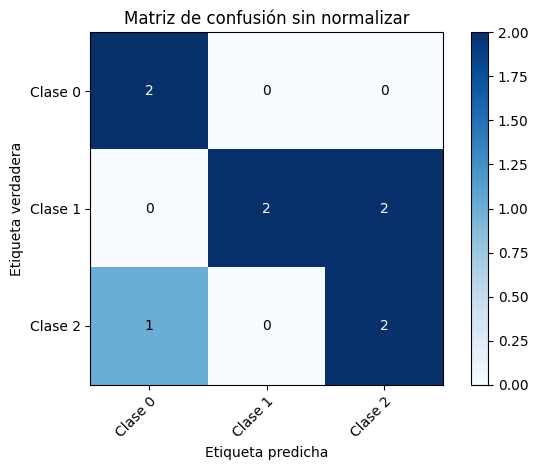

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    Esta función imprime y traza la matriz de confusión.
    La normalización se puede aplicar configurando el parámetro `normalize=True`.
    """
    # Crear un mapeo de clases a índices numéricos
    class_to_index = {cls: idx for idx, cls in enumerate(classes)}
    # Convertir las categorías a valores numéricos
    y_true_numeric = [class_to_index[cls] for cls in y_true]
    y_pred_numeric = [class_to_index[cls] for cls in y_pred]

    if not title:
        if normalize:
            title = 'Matriz de confusión normalizada'
        else:
            title = 'Matriz de confusión sin normalizar'

    # Calcular matriz de confusión
    cm = confusion_matrix(y_true_numeric, y_pred_numeric)

    # Normalizar la matriz de confusión si es necesario
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalizar')

    # Imprimir matriz de confusión
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # Mostrar todas las etiquetas de las clases
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta verdadera',
           xlabel='Etiqueta predicha')

    # Rotar las etiquetas del eje x para que sean legibles
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Rellenar la matriz con los valores
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Ejemplo de uso:
y_true = ["Clase 2", "Clase 0", "Clase 2", "Clase 2", "Clase 0", "Clase 1", "Clase 1", "Clase 1", "Clase 1"]
y_pred = ["Clase 0", "Clase 0", "Clase 2", "Clase 2", "Clase 0", "Clase 2", "Clase 1", "Clase 1", "Clase 2"]
classes = ['Clase 0', 'Clase 1', 'Clase 2']

plot_confusion_matrix(y_true, y_pred, classes=classes, normalize=False, title='Matriz de confusión sin normalizar')
plt.show()


Total Accuracy: 0.8596491228070176
Total Precision: 0.7779503105590062
Total Recall: 0.7752351894228324
Total F1 Score: 0.7761503863452889


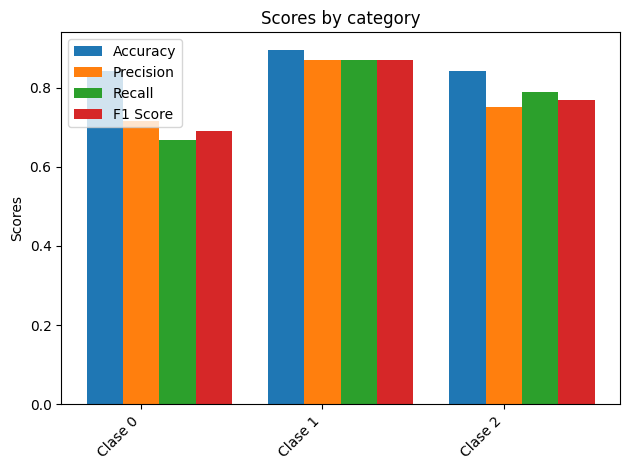

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(cm):
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    TN = np.sum(cm) - (TP + FP + FN)

    accuracy = (TP + TN) / np.sum(cm)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * ((precision * recall) / (precision + recall))

    total_accuracy = np.sum(accuracy) / len(accuracy)
    total_precision = np.sum(precision) / len(precision)
    total_recall = np.sum(recall) / len(recall)
    total_f1_score = np.sum(f1_score) / len(f1_score)

    return accuracy, precision, recall, f1_score, total_accuracy, total_precision, total_recall, total_f1_score

def plot_metrics(categories, accuracy, precision, recall, f1_score):
    x = np.arange(len(categories))
    width = 0.2

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, accuracy, width, label='Accuracy')
    rects2 = ax.bar(x, precision, width, label='Precision')
    rects3 = ax.bar(x + width, recall, width, label='Recall')
    rects4 = ax.bar(x + 2 * width, f1_score, width, label='F1 Score')

    ax.set_ylabel('Scores')
    ax.set_title('Scores by category')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

def print_metrics(total_accuracy, total_precision, total_recall, total_f1_score):
    print(f"Total Accuracy: {total_accuracy}")
    print(f"Total Precision: {total_precision}")
    print(f"Total Recall: {total_recall}")
    print(f"Total F1 Score: {total_f1_score}")

# Ejemplo de uso:
categories = ['Clase 0', 'Clase 1', 'Clase 2']
cm = np.array([[10, 2, 3],
               [1, 20, 2],
               [3, 1, 15]])

accuracy, precision, recall, f1_score, total_accuracy, total_precision, total_recall, total_f1_score = calculate_metrics(cm)
print_metrics(total_accuracy, total_precision, total_recall, total_f1_score)
plot_metrics(categories, accuracy, precision, recall, f1_score)

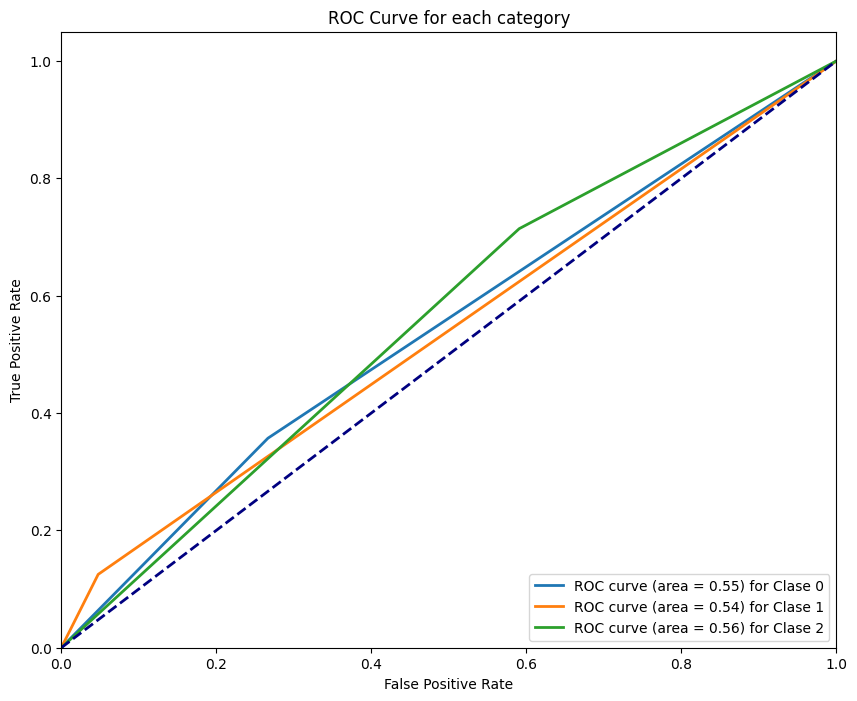

In [54]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer

def plot_roc_curve(y_true, y_pred, classes):
    """
    Esta función traza la curva ROC para cada categoría con sus propias líneas.
    """
    n_classes = len(classes)

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        # Convertir las etiquetas de las clases a valores binarios
        lb = LabelBinarizer()
        y_true_binary = lb.fit_transform(y_true)
        y_pred_binary = lb.transform(y_pred)
        
        fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred_binary[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f}) for {classes[i]}')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for each category')
    plt.legend(loc="lower right")
    plt.show()

# Ejemplo de uso:
y_true = ["Clase 0", "Clase 1", "Clase 2", "Clase 0", "Clase 1", "Clase 0", "Clase 1", "Clase 2", "Clase 0", "Clase 0", "Clase 1", "Clase 2", "Clase 0", "Clase 0", "Clase 1", "Clase 2", "Clase 0", "Clase 0", "Clase 1", "Clase 2", "Clase 0", "Clase 0", "Clase 1", "Clase 2", "Clase 0", "Clase 0", "Clase 1", "Clase 2", "Clase 0"]
y_pred = ["Clase 1", "Clase 1", "Clase 2", "Clase 0", "Clase 2", "Clase 2", "Clase 0", "Clase 2", "Clase 2", "Clase 0", "Clase 2", "Clase 2", "Clase 0", "Clase 2", "Clase 2", "Clase 0", "Clase 2", "Clase 2", "Clase 0", "Clase 2", "Clase 2", "Clase 0", "Clase 2", "Clase 2", "Clase 0", "Clase 2", "Clase 2", "Clase 0", "Clase 2"]

classes = ['Clase 0', 'Clase 1', 'Clase 2']

plot_roc_curve(y_true, y_pred, classes)


In [56]:
import pandas as pd

# Leer el archivo CSV
no_trained_comments = pd.read_csv("clean_comments_categorized.csv", names=['comment', 'category'])
trained_comments = pd.read_csv("train_comments.csv", names=['comment', 'category'])

# Acceder a las primeras filas de trained_comments
print("Trained Comments:")
print(trained_comments.head())

# Acceder a las primeras filas de no_trained_comments
print("No Trained Comments:")
print(no_trained_comments.head())

Trained Comments:
                                             comment           category
0  I have never commented on a political video be...   Apoyo Entusiasta
1  Milei’s unwavering commitment to free-market p...   Apoyo Entusiasta
2  When your friends ask you what are your econom...   Apoyo Entusiasta
3  We are hearing one of the most important polit...   Apoyo Entusiasta
4  Argentina have won the lottery electing this m...   Apoyo Entusiasta
----------------------------------------------------------------------
No Trained Comments:
                                             comment  \
0                                 what an eye opener   
1  this is amazing do not yield to the advance of...   
2  dont let somebody else pick your friends or yo...   
3  he is very mistaken it isnt collectivism being...   
4             thank you and long live freedom damnit   

                            category  
0                   Debate Económico  
1   Preocupación por la Controversia  
2   

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch
import pandas as pd


def map_category_to_number(categories):
    category_number_list = []
    for category in categories:
        if category == 'Apoyo Entusiasta':
            category_number_list.append(0)
        elif category == 'Críticas Severas':
            category_number_list.append(1)            
        elif category == 'Debate Económico':
            category_number_list.append(2)
        elif category == 'Preocupación por la Controversia':
            category_number_list.append(3)
        elif category == 'Comparaciones con Otros Políticos':
            category_number_list.append(4)
        elif category == 'Humor y Sarcasmo':
            category_number_list.append(5)
        
    return category_number_list

# Leer el archivo CSV
no_trained_comments = pd.read_csv("clean_comments_categorized.csv", names=['comment', 'category'])
trained_comments = pd.read_csv("train_comments.csv", names=['comment', 'category'])

no_trained_labels = map_category_to_number(no_trained_comments["category"].values[:10])
trained_labels = map_category_to_number(trained_comments["category"].values)

no_trained_comments = no_trained_comments['comment'].values[:10]
trained_comments = trained_comments['comment'].values



# Definir el conjunto de datos personalizado
class CustomDataset(Dataset):
    def __init__(self, comments, labels_list):
        self.comments = comments
        self.labels_list = labels_list

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        return {'text': self.comments[idx], 'label': self.labels_list[idx]}

####Preba 1#####
# Cargar el tokenizer y el modelo preentrenado de BART
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
encoded_training_data = tokenizer.batch_encode_plus(trained_comments, add_special_tokens=True, return_attention_mask=True, pad_to_max_length=True, max_length=256, return_tensors='pt')
input_ids_train = encoded_training_data['input_ids']
attention_masks_train = encoded_training_data['attention_mask']
labels = torch.tensor(trained_labels)


encoded_eval_data = tokenizer.batch_encode_plus(no_trained_comments, add_special_tokens=True, return_attention_mask=True, pad_to_max_length=True, max_length=256, return_tensors='pt')
input_ids_eval = encoded_eval_data['input_ids']
attention_masks_eval = encoded_eval_data['attention_mask']




model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, output_attentions=False, output_hidden_states=False)
# Define the training parameters
batch_size = 32
epochs = 3
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Train the model
for epoch in range(epochs):
    print(f"Epochs = {epoch}")
    model.train()
    for i in range(0, input_ids_train.size(0), batch_size):
        print(f"\t{i} - Dentro del segundo for")
        optimizer.zero_grad()
        print(f"\t{i} - Despues del zero_guard")
        outputs = model(input_ids_train[i:i+batch_size], attention_mask=attention_masks_train[i:i+batch_size], labels=labels[i:i+batch_size])
        print(f"\t{i} - Despues del outputs")
        loss = outputs.loss
        print(f"\t{i} - Despues del loss")
        loss.backward()
        print(f"\t{i} - Despues del backward")
        optimizer.steppredicted_categories = []
        

print(f"\n\n Entrenamiento terminado, comienza la evaluacion")

model.eval()
with torch.no_grad():
    outputs = model(input_ids_eval, attention_mask=attention_masks_eval)
    predicted_categories = torch.argmax(outputs[0], dim=1).flatten()

print(f"\n\nLas categorías predichas son: {predicted_categories}")

### Prueba 2 #######
#Fine tuning del BARD
# train_dataset = CustomDataset(comments=trained_comments['comment'].values, labels_list=trained_labels)
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# optimizer = AdamW(model.parameters(), lr=5e-5)
# for epoch in range(1):  # Ejemplo: ajustar durante 3 épocas
#     model.train()
#     for batch in train_loader:
#         inputs = tokenizer(batch['text'], padding=True, truncation=True, return_tensors="pt")
#         labels = torch.tensor(batch['label']).unsqueeze(1)
#         outputs = model(**inputs, labels=labels)
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
# 
# #Evaluacion con bard queda las categorias predichas en predicted_categories
# predicted_categories = []
# 
# # Poner el modelo en modo de evaluación
# model.eval()
# bart_command = "I want you to give me just the category for this comment based on your previous training as response, the categories are: 0,1,2,3,4,5 and the comment is: \n"
# for comment in no_trained_comments["comment"].values[:10]:
#     input_ids = tokenizer.encode(comment, return_tensors='pt', max_length=512, truncation=True)  # Truncar las secuencias a una longitud máxima
#     with torch.no_grad():
#         outputs = model.generate(input_ids, max_length=100, num_beams=4, temperature=1.0)
#     predicted_label = tokenizer.decode(outputs[0], skip_special_tokens=True)
#     predicted_categories.append(predicted_label)
#     print(f"Iteracion: {comment}")
# 
# print(f"\n\nLas categorías predichas son: {predicted_categories}")


# Origianl
# model.eval()
# for comment in no_trained_comments["comment"].values:
#     input_ids = tokenizer.encode(comment, return_tensors='pt', max_length=512)
#     with torch.no_grad():
#         outputs = model(input_ids)
#     logits = outputs.logits
#     predicted_label = torch.argmax(logits, dim=1).item()
#     predicted_categories.append(predicted_label)
#print(f"La categoiras predichas son: {predicted_categories}")

# Tokenizar el texto de entrada
# inputs = tokenizer([text], max_length=1024, return_tensors='pt', truncation=True)
# # Generar el resumen utilizando el modelo BART
# summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=150, early_stopping=True)
# # Decodificar y imprimir el resumen
# summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
# print("Resumen: ", summary)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/lucas/Documents/ITBA/Quinto_Ano_1-2_2024/NLP/TPE-NLP/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of BertForSequenceClassification 

Epochs = 0
0 - Dentro del segundo for
0 - Despues del zero_guard
0 - Despues del outputs
0 - Despues del loss
0 - Despues del backward
32 - Dentro del segundo for
32 - Despues del zero_guard
32 - Despues del outputs
32 - Despues del loss
32 - Despues del backward
64 - Dentro del segundo for
64 - Despues del zero_guard
64 - Despues del outputs
64 - Despues del loss
64 - Despues del backward
96 - Dentro del segundo for
96 - Despues del zero_guard
96 - Despues del outputs
96 - Despues del loss
96 - Despues del backward
128 - Dentro del segundo for
128 - Despues del zero_guard
128 - Despues del outputs
128 - Despues del loss
128 - Despues del backward
Epochs = 1
0 - Dentro del segundo for
0 - Despues del zero_guard
0 - Despues del outputs
0 - Despues del loss
0 - Despues del backward
32 - Dentro del segundo for
32 - Despues del zero_guard
32 - Despues del outputs
32 - Despues del loss
32 - Despues del backward
64 - Dentro del segundo for
64 - Despues del zero_guard
64 - Despues del outputs

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

def generate_summaries(texts, categories):
    # Cargar el tokenizer y el modelo preentrenado de BART
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
    model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

    summaries = []

    for text, category in zip(texts, categories):
        # Combinar texto y categoría para formar el input
        combined_text = f"{text} {category}"

        # Tokenizar el texto de entrada
        inputs = tokenizer([combined_text], max_length=1024, return_tensors='pt', truncation=True)

        # Generar el resumen utilizando el modelo BART
        summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=150, early_stopping=True)

        # Decodificar y guardar el resumen
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)

    return summaries

# Ejemplo de uso:
texts = ["Las instalaciones son muy acogedoras.",
         "Las cabañas mas lindas del mundo, con salida al lago y una tranquilidad superior."]
categories = ["Acogedoras", "Tranquilidad"]

generated_summaries = generate_summaries(texts, categories)
for text, category, summary in zip(texts, categories, generated_summaries):
    print(f"Texto: {text}\nCategoría: {category}\nResumen: {summary}\n")
    


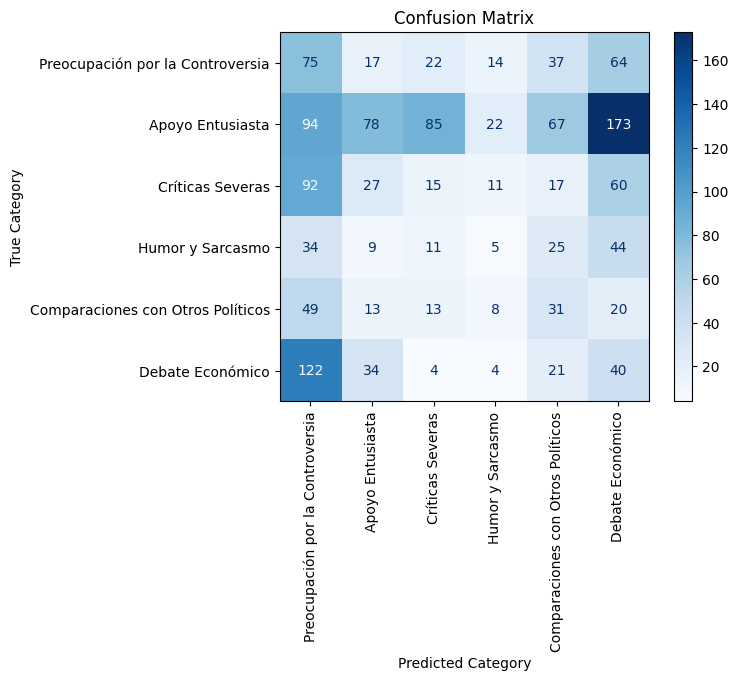

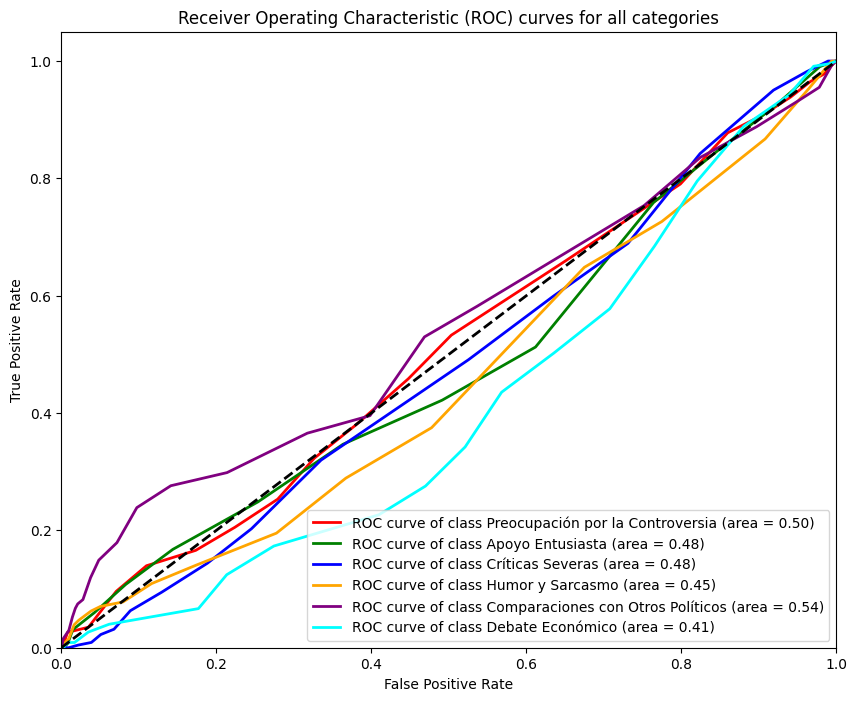

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from itertools import cycle

def map_category_to_number(categories):
    category_mapping = {category: idx for idx, category in enumerate(set(categories))}
    return [category_mapping[category] for category in categories], category_mapping

def map_number_to_category(numbers, category_mapping):
    inverse_mapping = {v: k for k, v in category_mapping.items()}
    return [inverse_mapping[number] for number in numbers]

# Leer los archivos CSV
trained_comments = pd.read_csv("train_comments.csv", names=['comment', 'category'])
trained_labels, category_mapping = map_category_to_number(trained_comments["category"].values)

no_trained_comments = pd.read_csv("clean_comments_categorized.csv", names=['comment', 'category'])
no_trained_labels, aux = map_category_to_number(no_trained_comments["category"].values)

trained_comments_texts = trained_comments['comment'].values
no_trained_comments_texts = no_trained_comments['comment'].values

""" trained_comments = pd.read_csv("clean_comments_categorized.csv", names=['comment', 'category'])
trained_labels, category_mapping = map_category_to_number(trained_comments["category"].values[:400])

no_trained_comments = pd.read_csv("clean_comments_categorized.csv", names=['comment', 'category'])
no_trained_labels, aux = map_category_to_number(no_trained_comments["category"].values[400:])

trained_comments_texts = trained_comments['comment'].values[:400]
no_trained_comments_texts = no_trained_comments['comment'].values[400:] """

# Vectorizar los comentarios utilizando TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(trained_comments_texts)
X_test = vectorizer.transform(no_trained_comments_texts)

# Crear y entrenar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train, trained_labels)

predictions = knn.predict(X_test)

cm = confusion_matrix(no_trained_labels, predictions)

category_labels = list(category_mapping.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=category_labels)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix')
plt.show()

# Binarizar las etiquetas
lb = LabelBinarizer()
lb.fit(trained_labels)
y_train_bin = lb.transform(trained_labels)
y_test_bin = lb.transform(no_trained_labels)

# Obtener las probabilidades para el cálculo de ROC
y_score = knn.predict_proba(X_test)

# Calcular ROC y AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(category_labels)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

custom_colors = ['red', 'green', 'blue', 'orange', 'purple', 'aqua']

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), custom_colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(category_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curves for all categories')
plt.legend(loc="lower right")
plt.show()

In [13]:
!pip install imbalanced-learn


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/5a/fa/267de06c95210580f4b82b45cec1ce1e9ce1f21a01a684367db89e7da70d/imbalanced_learn-0.12.3-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/258.3 kB ? eta -:--:--
   --------------- ------------------------ 102.4/258.3 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 258.3/258.3 kB 3.2 MB/s eta 0:00:00


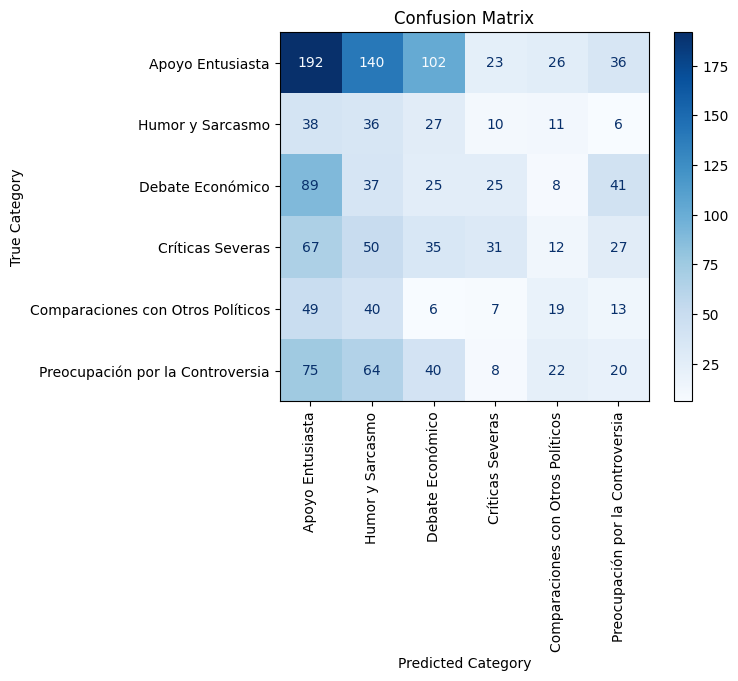

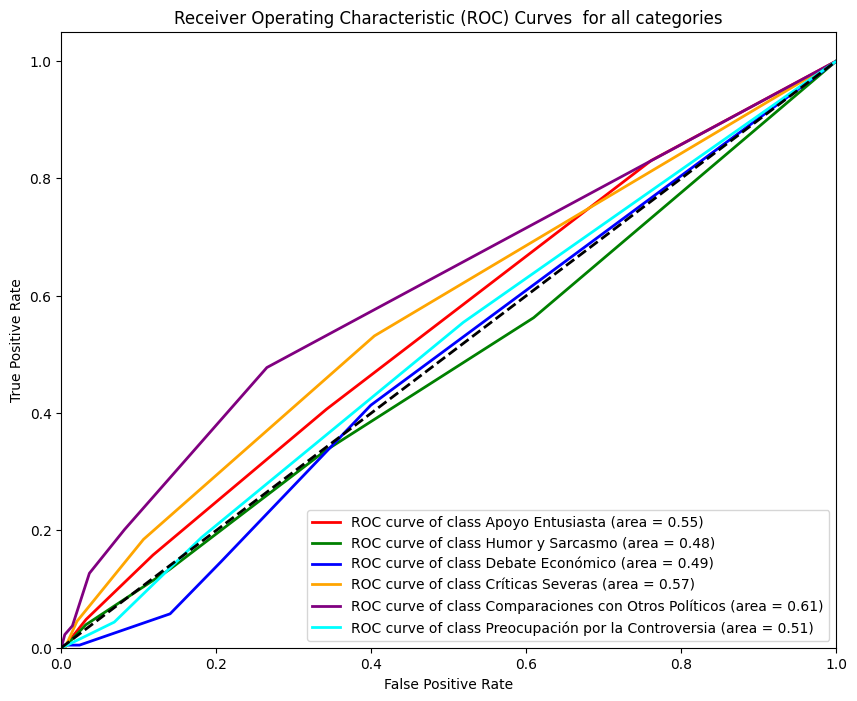

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from itertools import cycle

def map_category_to_number(categories):
    category_mapping = {category: idx for idx, category in enumerate(set(categories))}
    return [category_mapping[category] for category in categories], category_mapping

# Leer los archivos CSV
trained_comments = pd.read_csv("train_comments.csv", names=['comment', 'category'])
no_trained_comments = pd.read_csv("clean_comments_categorized.csv", names=['comment', 'category'])

trained_labels, category_mapping = map_category_to_number(trained_comments["category"].values)
no_trained_labels, _ = map_category_to_number(no_trained_comments["category"].values)

trained_comments_texts = trained_comments['comment'].values
no_trained_comments_texts = no_trained_comments['comment'].values

# Vectorizar los comentarios utilizando TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(trained_comments_texts)
X_test = vectorizer.transform(no_trained_comments_texts)

# Aplicar downsampling
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, trained_labels)

# Crear y entrenar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_res, y_train_res)

predictions = knn.predict(X_test)

cm = confusion_matrix(no_trained_labels, predictions)

category_labels = list(category_mapping.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=category_labels)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix')
plt.show()

# Binarizar las etiquetas
lb = LabelBinarizer()
lb.fit(trained_labels)
y_train_bin = lb.transform(trained_labels)
y_test_bin = lb.transform(no_trained_labels)

# Obtener las probabilidades para el cálculo de ROC
y_score = knn.predict_proba(X_test)

# Calcular ROC y AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(category_labels)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

custom_colors = ['red', 'green', 'blue', 'orange', 'purple', 'aqua']

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), custom_colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(category_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves  for all categories')
plt.legend(loc="lower right")
plt.show()


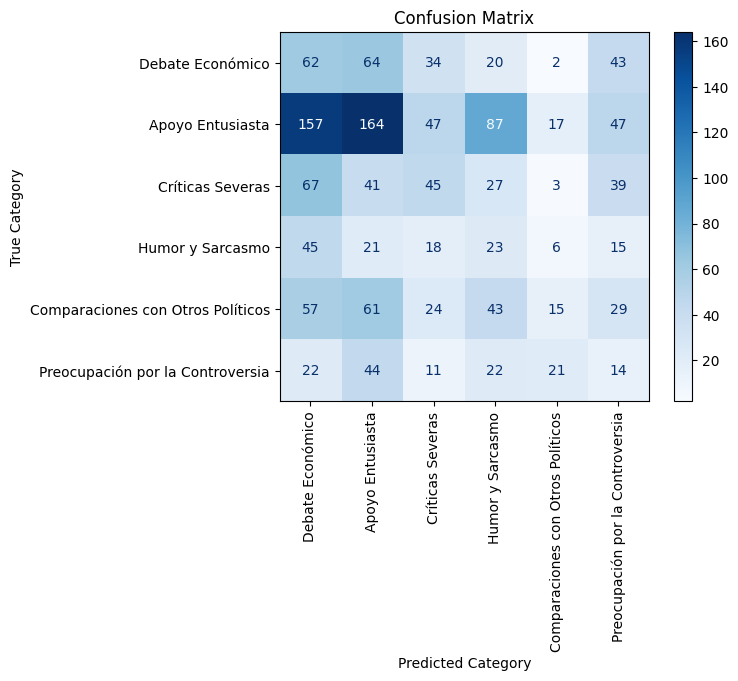

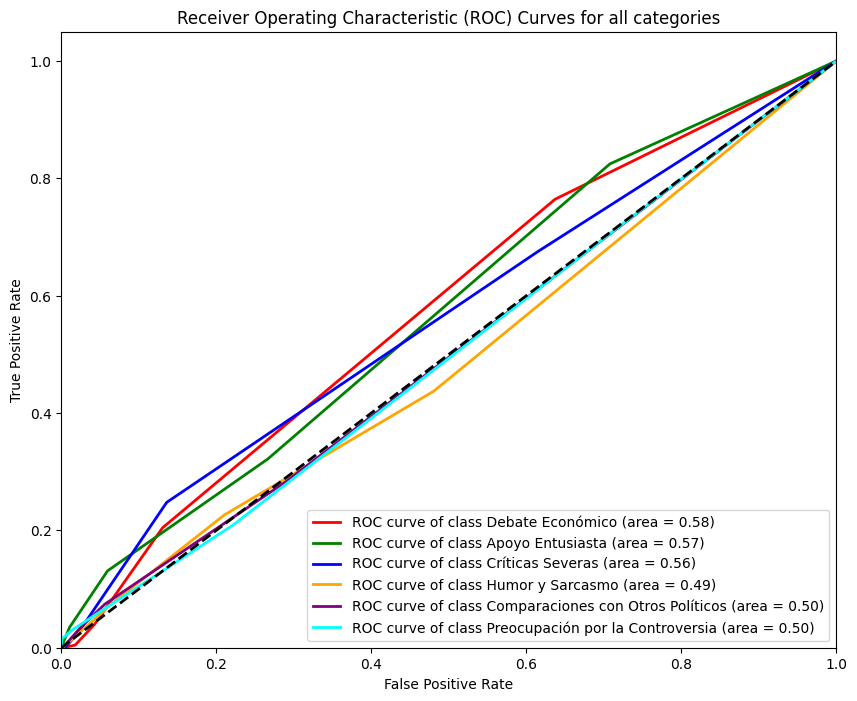

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from itertools import cycle

def map_category_to_number(categories):
    category_mapping = {category: idx for idx, category in enumerate(set(categories))}
    return [category_mapping[category] for category in categories], category_mapping

# Leer los archivos CSV
trained_comments = pd.read_csv("train_comments.csv", names=['comment', 'category'])
no_trained_comments = pd.read_csv("clean_comments_categorized.csv", names=['comment', 'category'])

trained_labels, category_mapping = map_category_to_number(trained_comments["category"].values)
no_trained_labels, _ = map_category_to_number(no_trained_comments["category"].values)

trained_comments_texts = trained_comments['comment'].values
no_trained_comments_texts = no_trained_comments['comment'].values

# Vectorizar los comentarios utilizando TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(trained_comments_texts)
X_test = vectorizer.transform(no_trained_comments_texts)

# Aplicar upsampling con SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, trained_labels)

# Crear y entrenar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_res, y_train_res)

predictions = knn.predict(X_test)

cm = confusion_matrix(no_trained_labels, predictions)

category_labels = list(category_mapping.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=category_labels)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix')
plt.show()

# Binarizar las etiquetas
lb = LabelBinarizer()
lb.fit(trained_labels)
y_train_bin = lb.transform(trained_labels)
y_test_bin = lb.transform(no_trained_labels)

# Obtener las probabilidades para el cálculo de ROC
y_score = knn.predict_proba(X_test)

# Calcular ROC y AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(category_labels)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

custom_colors = ['red', 'green', 'blue', 'orange', 'purple', 'aqua']

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), custom_colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(category_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for all categories')
plt.legend(loc="lower right")
plt.show()


Test metrics
Accuracy: 0.21688400823610157
Recall: 0.18125637945364462
Precision: 0.19546746503343618
F1: 0.17601245834946613
-------------------------------------
Train metrics
Accuracy: 0.9933333333333333
Recall: 0.9933333333333333
Precision: 0.9935897435897436
F1: 0.9933306655995732


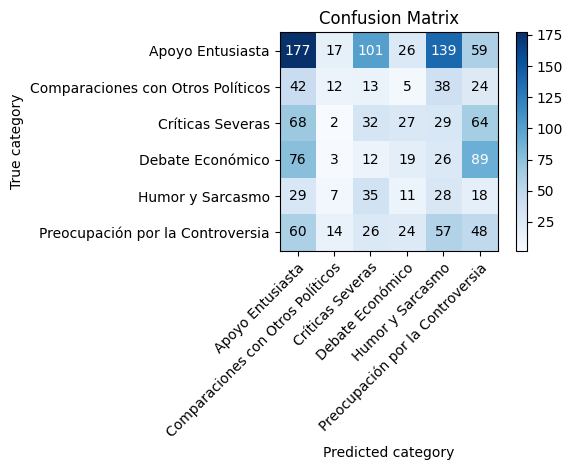

Total Accuracy: 0.7389613360787005
Total Precision: 0.19546746503343618
Total Recall: 0.18125637945364462
Total F1 Score: 0.17601245834946613


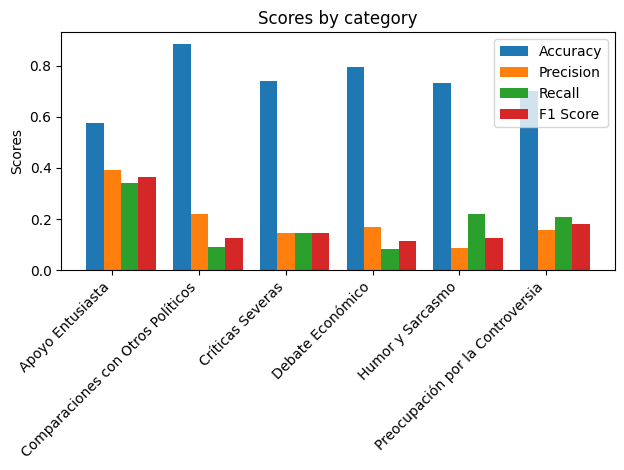

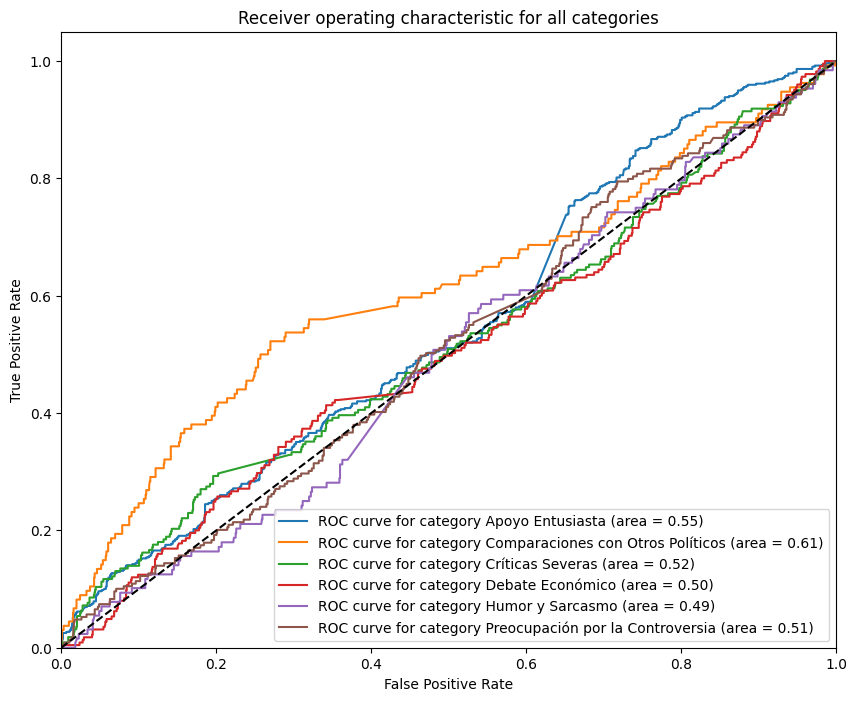

In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import chain


def flatten(matrix):
    return list(chain.from_iterable(matrix))

def apply_balance(df, method='upsampling', random_seed=42):
    if method == 'upsampling':
        max_class_count = df['category'].value_counts().max()
        df = df.groupby('category').apply(lambda x: x.sample(max_class_count, replace=True, random_state=random_seed)).reset_index(drop=True)
    elif method == 'downsampling':
        min_class_count = df['category'].value_counts().min()
        df = df.groupby('category').apply(lambda x: x.sample(min_class_count, random_state=random_seed)).reset_index(drop=True)
    return df

def train_test_split_data(X, y, test_size=0.1, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def train_logistic_regression(X_train, y_train, max_iter=10000):
    model = LogisticRegression(max_iter=max_iter)
    model.fit(X_train, y_train)
    return model


def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print("Test metrics")
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("Precision:", precision)
    print("F1:", f1)
    print("-------------------------------------")
    print("Train metrics")
    print("Accuracy:", accuracy_score(y_train, model.predict(X_train)))
    print("Recall:", recall_score(y_train, model.predict(X_train), average='macro'))
    print("Precision:", precision_score(y_train, model.predict(X_train), average='macro'))
    print("F1:", f1_score(y_train, model.predict(X_train), average='macro'))

    return accuracy, recall, precision, f1

def plot_confusion_matrix(y_test, y_pred, idx2categories):
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=idx2categories.values(), yticklabels=idx2categories.values(),
           title='Confusion Matrix',
           ylabel='True category',
           xlabel='Predicted category')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()
    plt.show()

def plot_roc_curve(y, y_test, y_score, idx2categories):
    # Binarize the output
    y = label_binarize(y, classes=[*range(len(idx2categories))])
    n_classes = y.shape[1]
    y_test = label_binarize(y_test, classes=[*range(len(idx2categories))])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for all classes
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve for category %s (area = %0.2f)' % (idx2categories[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for all categories')
    plt.legend(loc="lower right")
    plt.show()


def load_csv_files(train_file, test_file):
    train_df = pd.read_csv(train_file, names=['comment', 'category'])
    test_df = pd.read_csv(test_file, names=['comment', 'category'])
    return train_df, test_df

# Load your data
train_file = 'train_comments.csv'
test_file = 'clean_comments_categorized.csv'
train_df, test_df = load_csv_files(train_file, test_file)

# Clean and balance the data
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Balance classes if necessary
BALANCE_CLASSES = True
BALANCED_METHOD = 'downsampling' # or 'downsampling' 'upsampling' 
RANDOM_SEED = 42

if BALANCE_CLASSES:
    train_df = apply_balance(train_df, method=BALANCED_METHOD, random_seed=RANDOM_SEED)

# Vectorize the comments
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['comment'].values)
X_test = vectorizer.transform(test_df['comment'].values)

categories2idx = {category: idx for idx, category in enumerate(train_df['category'].unique())}
idx2categories = {idx: category for category, idx in categories2idx.items()}

y_train = train_df['category'].map(categories2idx).values
y_test = test_df['category'].map(categories2idx).values

# Train test split (already split here but keeping function for potential usage)
# X_train, X_test, y_train, y_test = train_test_split_data(X, y, test_size=0.1, random_state=42)

# Train logistic regression model
model = train_logistic_regression(X_train, y_train)

# Evaluate model
accuracy, recall, precision, f1 = evaluate_model(model, X_train, X_test, y_train, y_test)

# Plot confusion matrix
y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred, idx2categories)

# Calculate and print detailed metrics
cm = confusion_matrix(y_test, y_pred)
accuracy, precision, recall, f1_score, total_accuracy, total_precision, total_recall, total_f1_score = calculate_metrics(cm)
print_metrics(total_accuracy, total_precision, total_recall, total_f1_score)

# Plot metrics
categories = list(idx2categories.values())
plot_metrics(categories, accuracy, precision, recall, f1_score)

# Plot ROC curve
y_score = model.decision_function(X_test)
plot_roc_curve(y_train, y_test, y_score, idx2categories)